# Investigating the wind force influence on Kalman filtered data
Comparing lake data with simulation with a model that is unaware of the wind and with one that is aware of it.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [64]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from scipy.optimize import least_squares
import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests_ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loaders = catalog.load(f"{ship}.models")
units = catalog.load(f"{ship}.units")

[07/10/23 14:25:13] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=308795;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=167454;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/10/23 14:25:22] INFO     Kedro project phd                                                      ]8;id=624492;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=392554;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=717016;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=273500;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=989263;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=440117;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests_ek_smooth' (PartitionedDataSet)...     ]8;id=961233;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=350417;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=902419;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=618460;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=317698;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=570228;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=94079;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=56635;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=425422;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=172219;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=470699;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=224586;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
time_series_meta_data.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,psi,phi,y_GPS,x_GPS,x0,y0,u,v,r,u1d,v1d,r1d,aws,awa,V,U,beta,tws,twa,zigzag_test_id,inbetween_zigzags_id,date,missions,type,time_series
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,0.175628,0.172414,1.637572,2.599364,2.408736,59.288041,18.321386,0.015447,0.231330,2.488504,1.487030,1.694987,0.250999,2.423934,1.522064,1.637990,63.379467,0.229169,0.006974,0.001312,-0.000608,0.002449,0.078864,-0.149783,-9.817212,0.227797,2.489710,1.497060,1.693252,0.249425,2.424102,1.636439,-0.041247,0.175628,0.015447,177.355077,979.733387,981.540847,177.351765,1.623726,0.003164,0.001859,0.001394,0.000026,0.000016,2.456906,0.236351,1.629921,1.629921,-0.001224,1.643470,1.532504,NaN,15.0,2021-04-28 09:59:07.245075,"Mission started at: 2021/4/29,9:22:58,command ...",inbetween,motoring_7m_all_data
0,-2.864242,-2.889786,2.234649,2.868355,2.832776,59.290854,18.324044,0.011661,-0.058411,1.826679,-3.087927,0.716626,-0.118637,1.810751,-3.054401,0.748773,100.000000,-3.127585,0.009372,0.001654,-0.000898,0.017665,0.109068,-0.097567,-9.823668,-0.058420,1.811687,-2.989640,0.715064,-0.119148,1.805596,0.741702,-0.049476,-2.864242,0.011661,330.864004,1292.087658,1289.648970,330.619592,2.213642,-0.056255,0.017060,-0.003203,-0.003675,0.000107,1.808642,-0.086549,2.223786,2.223786,0.025924,0.697774,0.251634,0.0,NaN,2021-04-28 10:27:01.224843,"ZigZag: start (59.29170990,18.32409477),ZigZag...",zigzag,motoring_7m_all_data
16,-3.066111,-3.003547,1.549029,-1.737815,-0.380608,59.288431,18.323445,0.025616,-0.338841,3.581301,-0.957529,2.693383,-0.158267,3.315870,-0.747517,2.338011,75.456209,-3.133967,0.009551,0.001808,-0.001829,-0.041992,0.122821,-0.277251,-9.812322,-0.336998,3.595232,-0.859189,2.704765,-0.177163,3.328282,2.347661,0.006174,-3.066111,0.025616,295.051010,1022.471283,1020.830261,295.218944,1.418175,0.210450,-0.042787,-0.000222,-0.000058,-0.000102,3.461757,-0.255802,1.461612,1.461612,-0.205979,2.490675,1.973609,NaN,16.0,2021-04-28 10:28:31.023738,"CMD 17 stopped. comment: ,CMD 18 started. run...",inbetween,motoring_7m_all_data
1,2.976625,2.998750,2.168764,1.477648,1.630257,59.282847,18.322966,0.022045,-0.282939,6.409136,-0.453019,4.581796,-0.283185,5.890818,-0.491481,4.070700,100.000000,-3.141585,0.008296,0.001285,-0.001100,-0.008247,0.114604,-0.222498,-9.828266,-0.258706,6.441708,-0.427223,4.606597,-0.256902,5.943986,4.109235,-0.028388,2.976625,0.022045,263.751884,400.585296,398.125072,264.628885,2.134668,0.042544,-0.008983,-0.000066,0.001760,-0.000225,6.192847,-0.257964,2.144862,2.144862,-0.020765,4.359403,2.578185,1.0,NaN,2021-04-28 10:41:19.614095,"ZigZag: start (59.28369141,18.32298660),ZigZag...",zigzag,motoring_7m_all_data
17,-0.110019,-0.022294,1.774129,7.598752,4.327226,59.283162,18.324503,0.016003,3.002105,3.223930,2.990428,4.230881,2.991158,3.343682,2.959904,4.328934,82.989640,-0.108259,0.007377,0.001617,-0.000957,-0.005229,0.098850,-0.171825,-9.818810,3.019764,3.182388,2.992630,4.214505,3.000101,3.301931,4.312902,-0.075170,-0.110019,0.016003,351.587730,435.056897,436.581909,351.136829,1.714860,0.052633,-0.006093,-0.001148,0.000189,0.000115,3.242159,3.012812,1.736634,1.736634,-0.047954,4.277259,2.987239,NaN,17.0,2021-04-28 10:42:51.812923,"Operation: 3 ,FollowCourse: start (59.28205872...",inbetween,motoring_7m_all_data


<Axes: xlabel='date'>

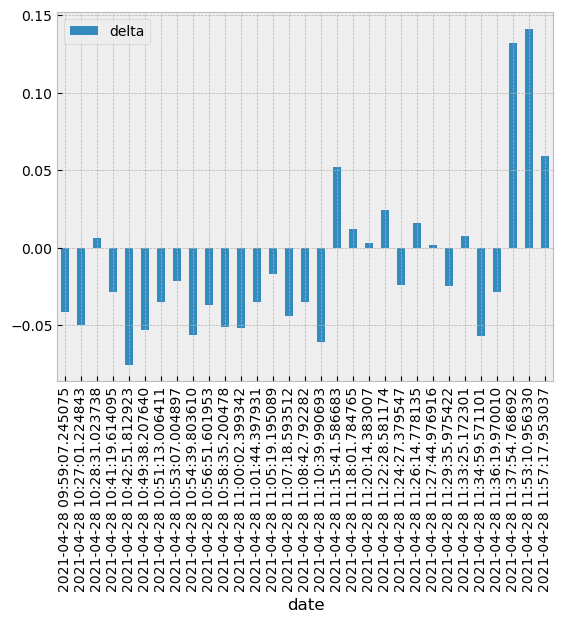

In [6]:
time_series_meta_data.plot.bar(x='date', y='delta')

In [7]:
model_no_wind = model_loaders['VCT_MDL_resistance']()
model_wind = model_loaders["VCT_MDL_resistance_wind"]()


## First determine the neutral rudder angle $\delta_0$

In [8]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

In [185]:
def calculate_forces(model, data, rev, delta):
    
    control = data[model.control_keys]
    states = data[['x0','y0','psi','u','v','r']]
    control['rev'] = rev
    control['delta'] = delta
    
    df_force_predicted = pd.DataFrame(model.calculate_forces(states_dict=states, control=control))
    df_force_predicted['fx'] = run(model.lambda_X_D, inputs=df_force_predicted)
    df_force_predicted['fy'] = run(model.lambda_Y_D, inputs=df_force_predicted)
    df_force_predicted['mz'] = run(model.lambda_N_D, inputs=df_force_predicted)
    
    return df_force_predicted
    

def predict_rev_delta(x, data:pd.DataFrame, df_force:pd.DataFrame, model):
    
    df_force_predicted = calculate_forces(model=model, data=data, rev=x[0], delta=x[1])
    
    residual = [(df_force['fx'] - df_force_predicted['fx']).mean(),
                (df_force['fy'] - df_force_predicted['fy']).mean(),
                (df_force['mz'] - df_force_predicted['mz']).mean()/ship_data['L']]
   
    return residual

def fit(model, data:pd.DataFrame):
    
    df_force = model.forces_from_motions(data=data)
    
    kwargs = {
        'data':data,
        'df_force':df_force,
        'model':model,
    }
    
    return least_squares(fun=predict_rev_delta, x0=[5.0,0.0], bounds=([0,-np.pi/4], [np.inf,np.pi/4]), kwargs=kwargs)

In [186]:
def set_initial_inputs(model, data:pd.DataFrame):
    result = fit(model=model_wind, data=data.iloc[-3:])
    rev_estimated = result.x[0]
    delta0_estimated = result.x[1]
    ddelta0 = delta0_estimated - data['delta'].iloc[0]
    data['delta']+=ddelta0  # Neutral rudder angle added
    data['rev'] = rev_estimated
    

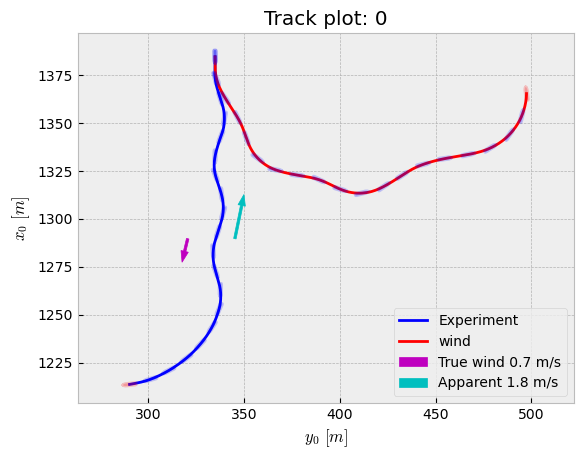

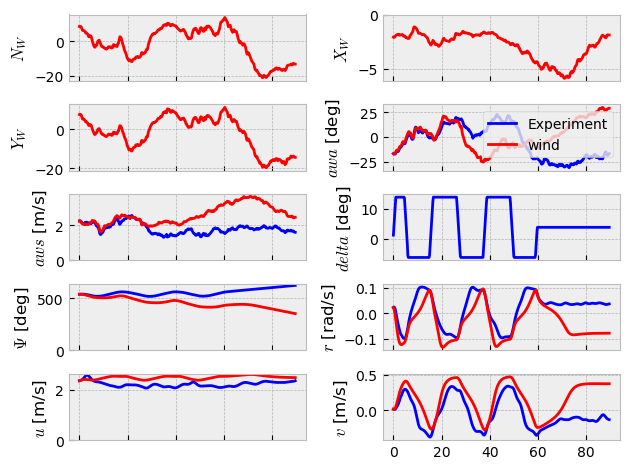

In [187]:
id = '0'
loader = time_series[id]
data = loader()
#data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)
#rev_guess = 15
#data['rev'] = rev_guess

#data['awa'] = smallest_signed_angle(data['awa'])
#data['F_Wx'] = run(lambda_F_Wx, inputs=data, **ship_data, **model_wind.parameters)
#data['F_Wy'] = run(lambda_F_Wy, inputs=data, **ship_data, **model_wind.parameters)
#data['M_Wz'] = run(lambda_M_Wz, inputs=data, **ship_data, **model_wind.parameters)

set_initial_inputs(model=model_wind, data=data)
result_wind = model_wind.simulate(data)


dataframes = {
    'Experiment':data,
    'wind':result_wind
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','X_W','Y_W','N_W'], time_window=time_window, units=units, symbols=symbols_dict);

In [188]:
mask = time_series_meta_data['type'] == 'zigzag'
time_series_meta_data_select = time_series_meta_data.loc[mask].sort_values(by='date')


results_no_wind = {}
results_wind = {}

for id, row in time_series_meta_data_select.iterrows():
    loader = time_series[id]
    
    data = loader()
    data.drop(columns=['mission','date'], inplace=True)
    set_initial_inputs(model=model_wind, data=data)
    try:
        result_wind = model_wind.simulate(data)
    except:
        log.error(f"Failed to simulate model_wind for: {id}")
    else:
        df_result_wind = result_wind.copy()
        results_wind[id] = df_result_wind
    

In [189]:
#catalog.save(f"{ ship }.modular.simulation_no_wind", results_no_wind)
catalog.save(f"{ ship }.modular.simulation_wind", results_wind)

[07/10/23 15:50:05] INFO     Saving data to '7m.modular.simulation_wind'                        ]8;id=338446;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=813587;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\
                             (PartitionedDataSet)...                                                               

## Simulations

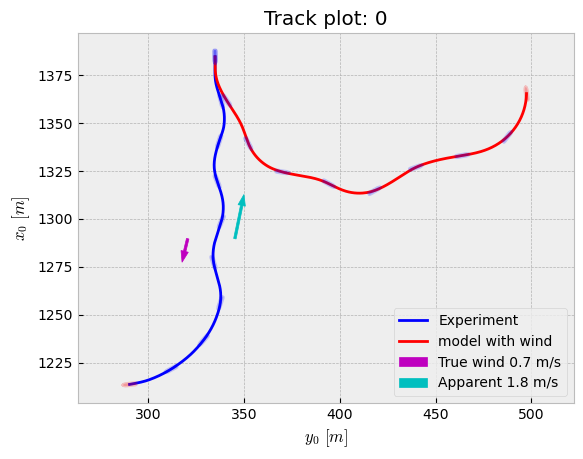

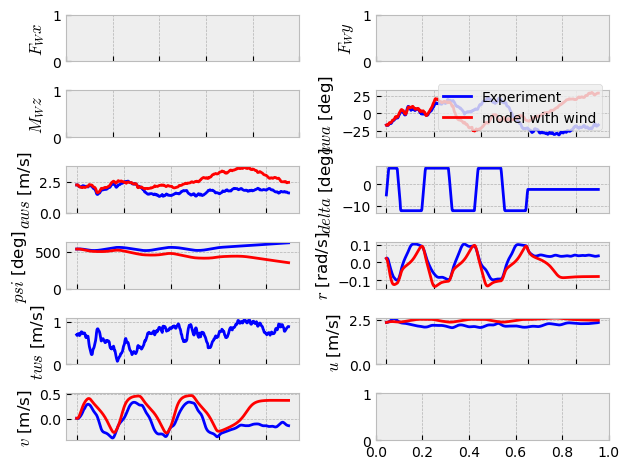

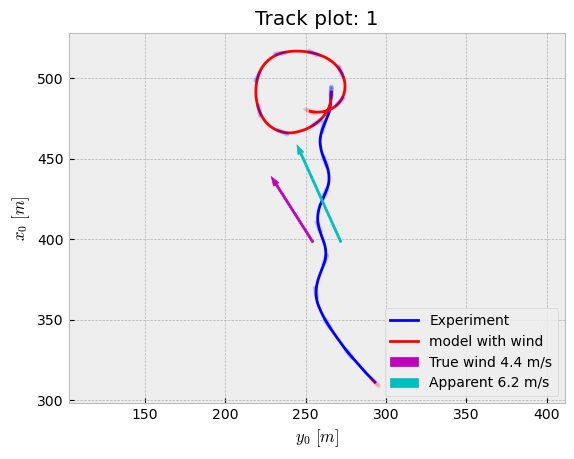

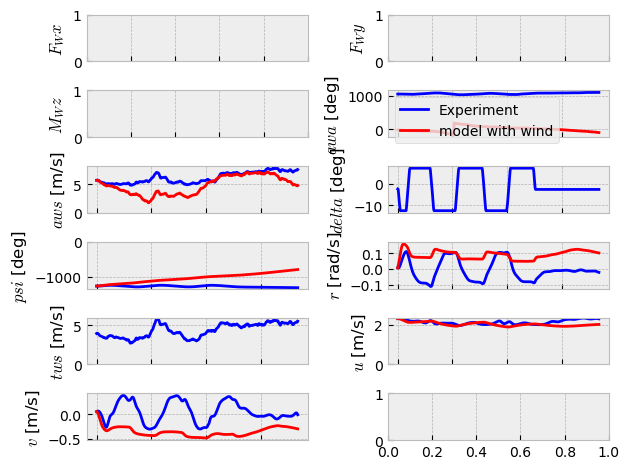

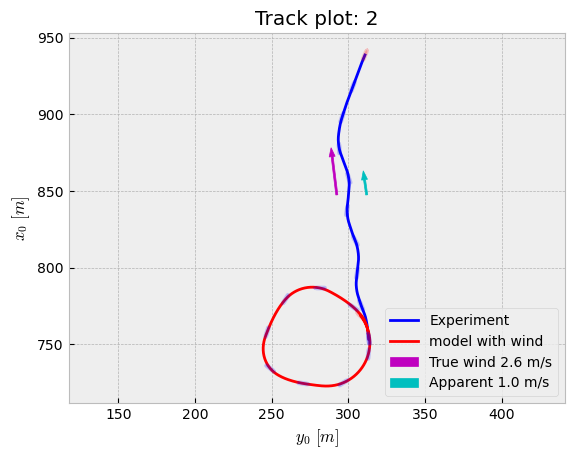

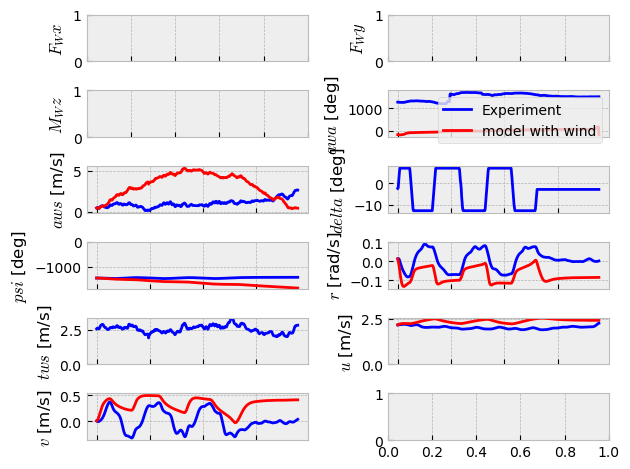

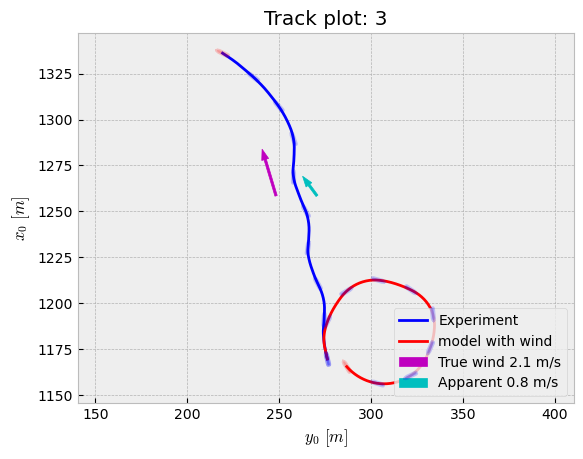

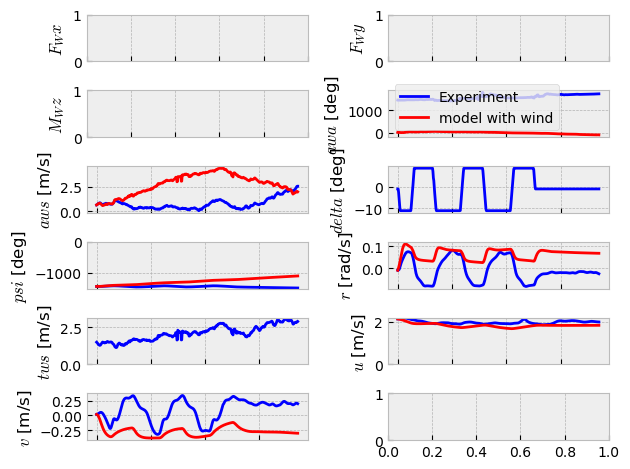

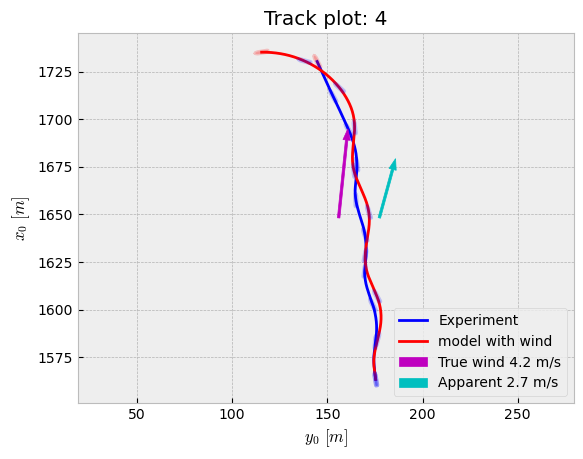

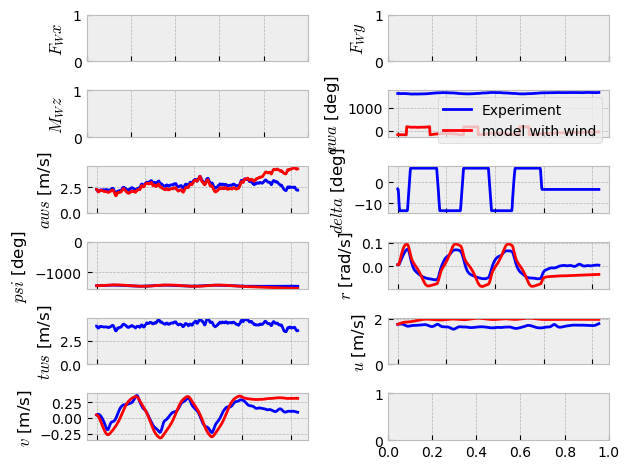

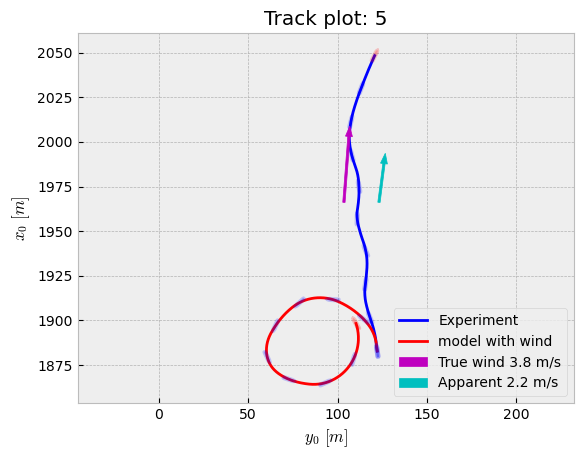

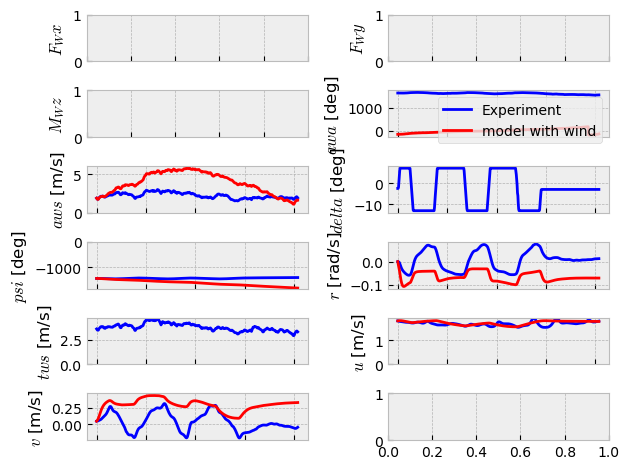

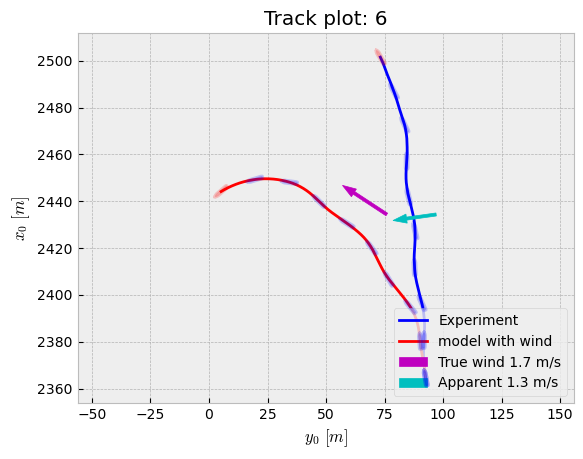

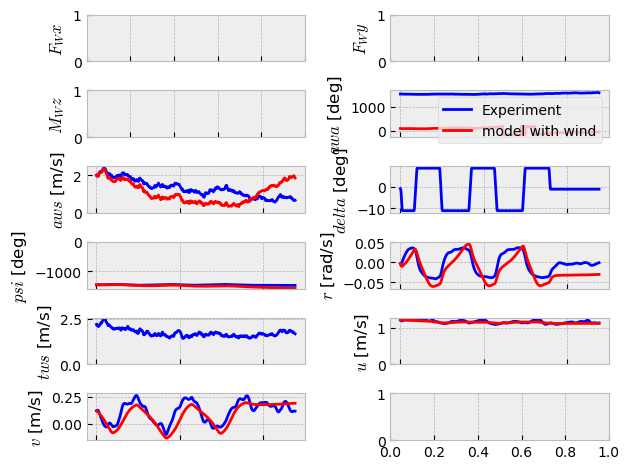

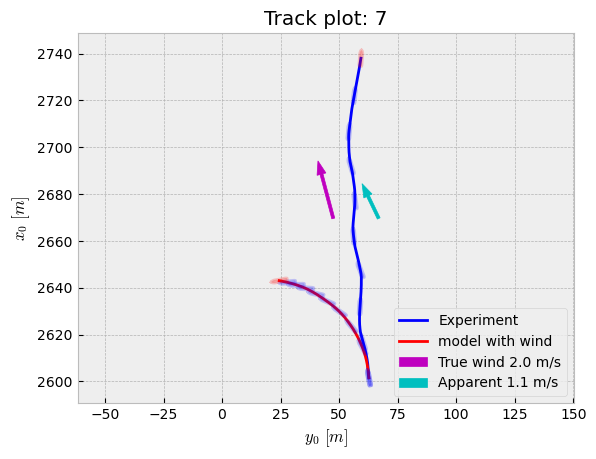

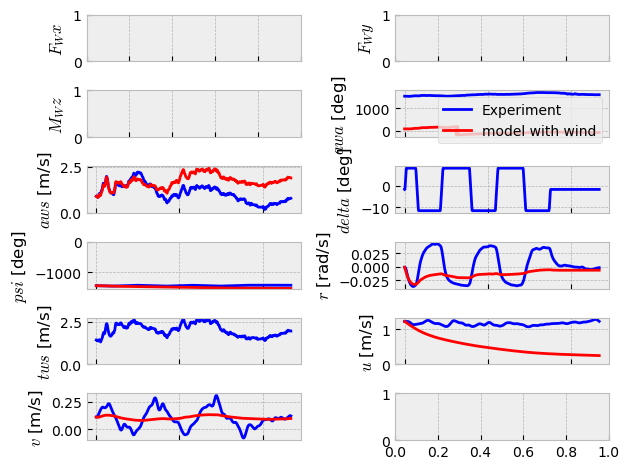

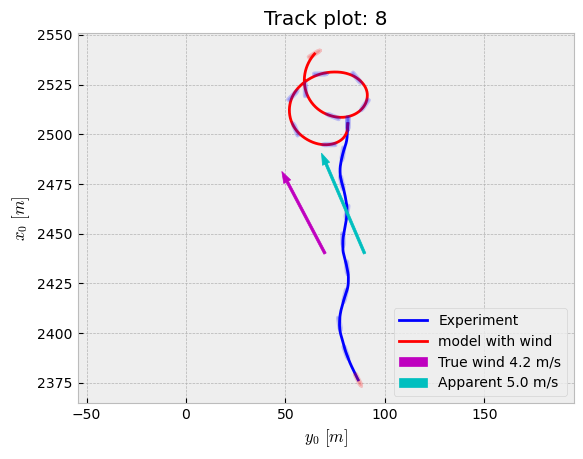

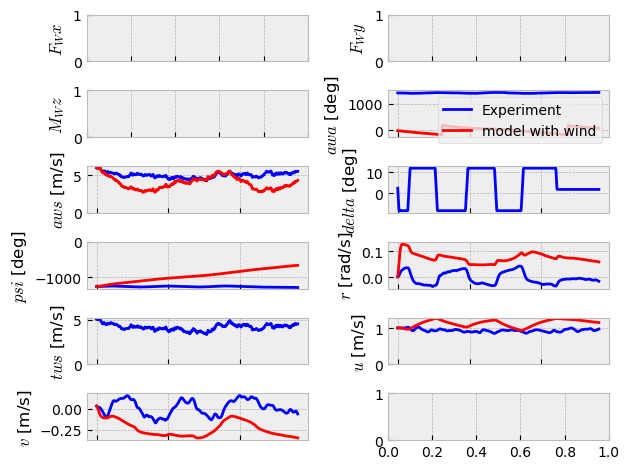

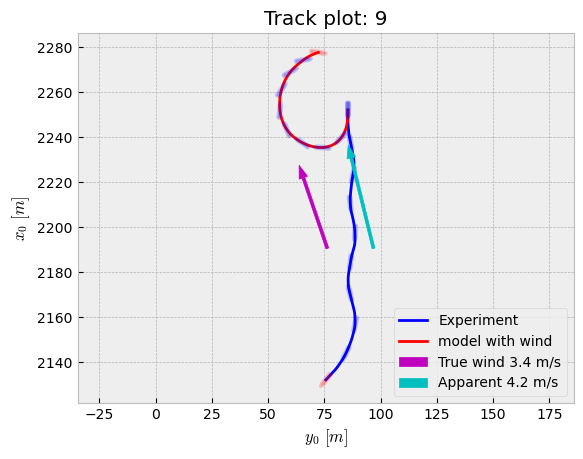

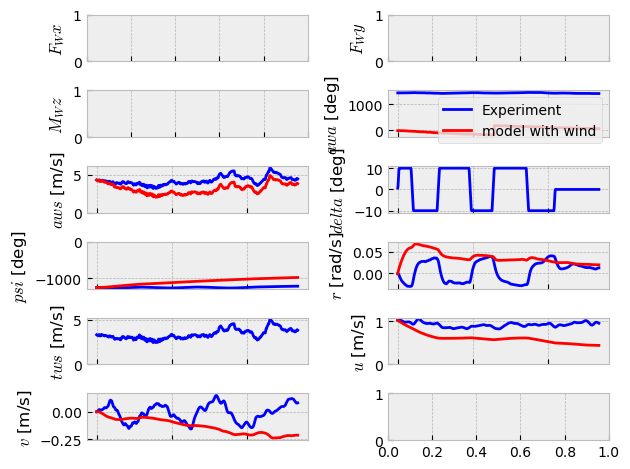

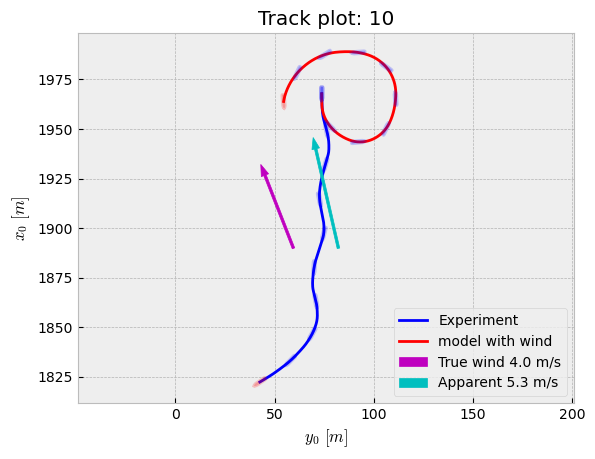

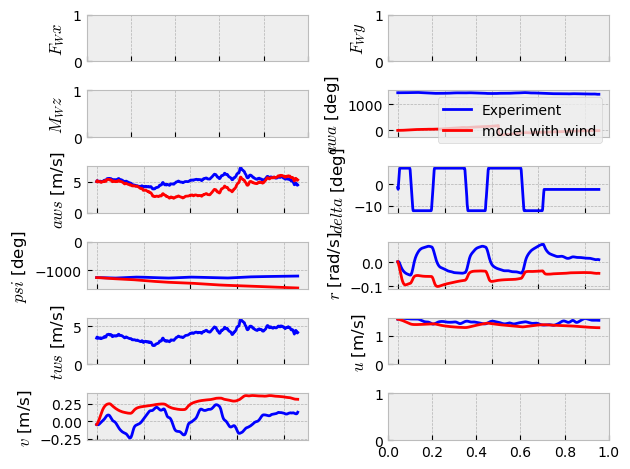

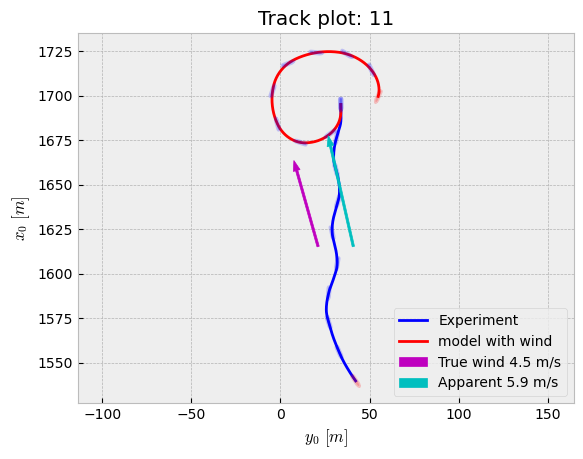

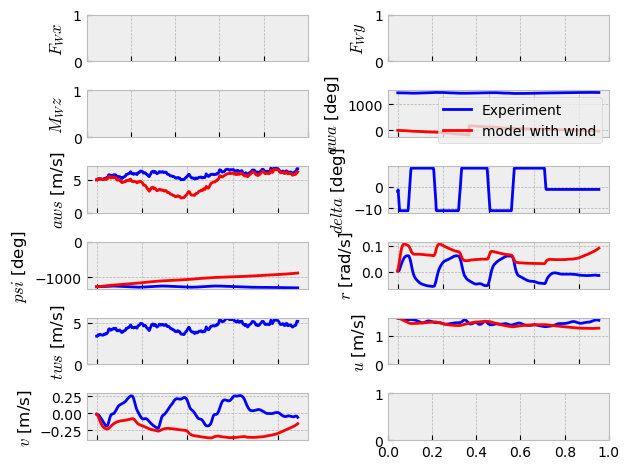

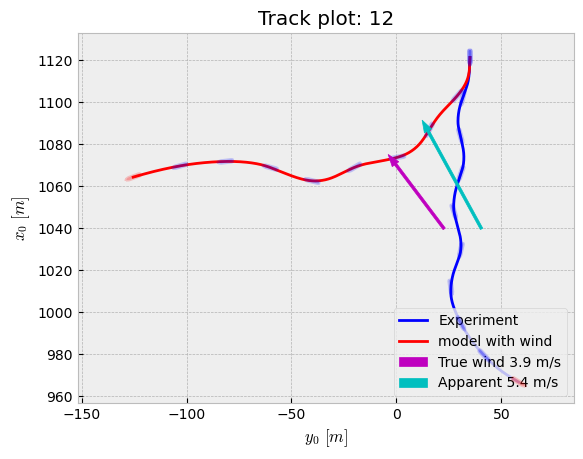

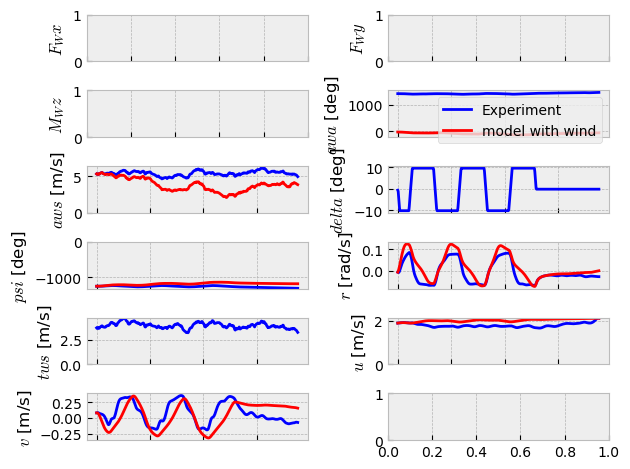

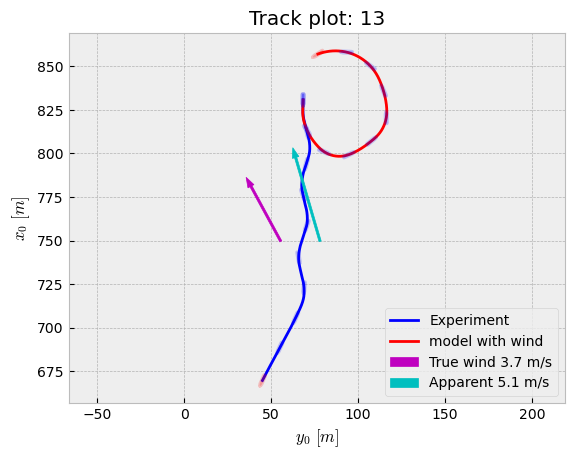

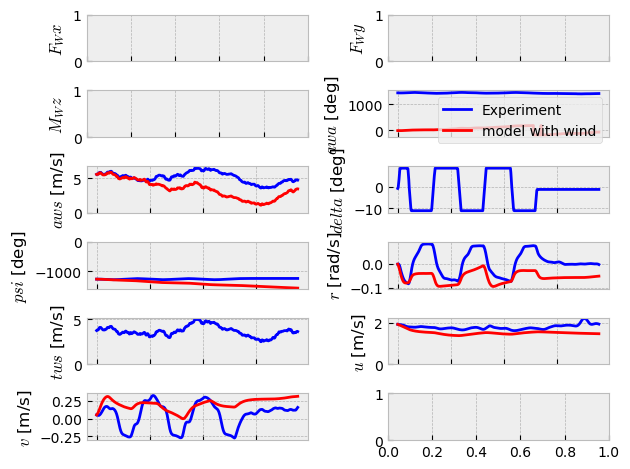

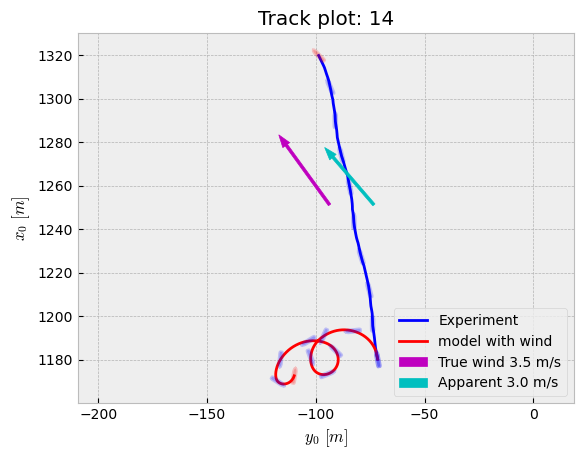

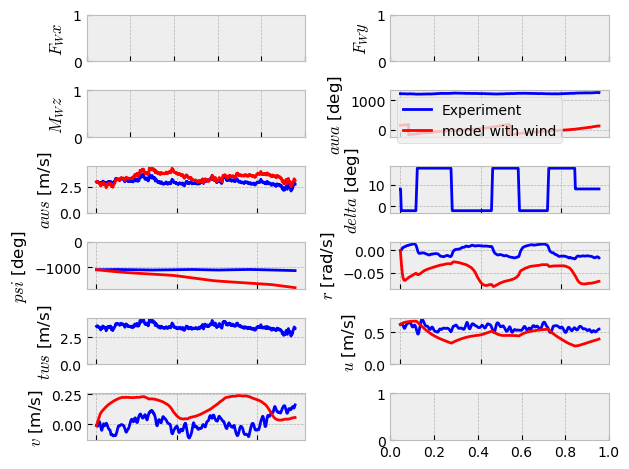

In [190]:
for id, row in time_series_meta_data_select.iterrows():
    
    loader = time_series[id]
    data = loader()
    #data = load(raw_data=data_raw)
    data.drop(columns=['mission','date'], inplace=True)
    #data['delta']-=delta0  # Neutral rudder angle added
        
    dataframes = {
    'Experiment':data,       
    }
    if id in results_no_wind:
        result_no_wind = results_no_wind[id]
        dataframes['no_wind'] = result_no_wind
    if id in results_wind:
        result_wind = results_wind[id]
        dataframes['model with wind'] = result_wind
            
    time_window=[0, np.inf]
    ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=10);
    ax.legend(loc='lower right')
    ax.set_title(f'Track plot: {id}') 
    
    plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','tws','F_Wx','F_Wy','M_Wz'], time_window=time_window, units=units);
    

In [191]:
time_series_meta_data.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,psi,phi,y_GPS,x_GPS,x0,y0,u,v,r,u1d,v1d,r1d,aws,awa,V,U,beta,tws,twa,zigzag_test_id,inbetween_zigzags_id,date,missions,type,time_series
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,0.175628,0.172414,1.637572,2.599364,2.408736,59.288041,18.321386,0.015447,0.231330,2.488504,1.487030,1.694987,0.250999,2.423934,1.522064,1.637990,63.379467,0.229169,0.006974,0.001312,-0.000608,0.002449,0.078864,-0.149783,-9.817212,0.227797,2.489710,1.497060,1.693252,0.249425,2.424102,1.636439,-0.041247,0.175628,0.015447,177.355077,979.733387,981.540847,177.351765,1.623726,0.003164,0.001859,0.001394,0.000026,0.000016,2.456906,0.236351,1.629921,1.629921,-0.001224,1.643470,1.532504,NaN,15.0,2021-04-28 09:59:07.245075,"Mission started at: 2021/4/29,9:22:58,command ...",inbetween,motoring_7m_all_data
0,-2.864242,-2.889786,2.234649,2.868355,2.832776,59.290854,18.324044,0.011661,-0.058411,1.826679,-3.087927,0.716626,-0.118637,1.810751,-3.054401,0.748773,100.000000,-3.127585,0.009372,0.001654,-0.000898,0.017665,0.109068,-0.097567,-9.823668,-0.058420,1.811687,-2.989640,0.715064,-0.119148,1.805596,0.741702,-0.049476,-2.864242,0.011661,330.864004,1292.087658,1289.648970,330.619592,2.213642,-0.056255,0.017060,-0.003203,-0.003675,0.000107,1.808642,-0.086549,2.223786,2.223786,0.025924,0.697774,0.251634,0.0,NaN,2021-04-28 10:27:01.224843,"ZigZag: start (59.29170990,18.32409477),ZigZag...",zigzag,motoring_7m_all_data
16,-3.066111,-3.003547,1.549029,-1.737815,-0.380608,59.288431,18.323445,0.025616,-0.338841,3.581301,-0.957529,2.693383,-0.158267,3.315870,-0.747517,2.338011,75.456209,-3.133967,0.009551,0.001808,-0.001829,-0.041992,0.122821,-0.277251,-9.812322,-0.336998,3.595232,-0.859189,2.704765,-0.177163,3.328282,2.347661,0.006174,-3.066111,0.025616,295.051010,1022.471283,1020.830261,295.218944,1.418175,0.210450,-0.042787,-0.000222,-0.000058,-0.000102,3.461757,-0.255802,1.461612,1.461612,-0.205979,2.490675,1.973609,NaN,16.0,2021-04-28 10:28:31.023738,"CMD 17 stopped. comment: ,CMD 18 started. run...",inbetween,motoring_7m_all_data
1,2.976625,2.998750,2.168764,1.477648,1.630257,59.282847,18.322966,0.022045,-0.282939,6.409136,-0.453019,4.581796,-0.283185,5.890818,-0.491481,4.070700,100.000000,-3.141585,0.008296,0.001285,-0.001100,-0.008247,0.114604,-0.222498,-9.828266,-0.258706,6.441708,-0.427223,4.606597,-0.256902,5.943986,4.109235,-0.028388,2.976625,0.022045,263.751884,400.585296,398.125072,264.628885,2.134668,0.042544,-0.008983,-0.000066,0.001760,-0.000225,6.192847,-0.257964,2.144862,2.144862,-0.020765,4.359403,2.578185,1.0,NaN,2021-04-28 10:41:19.614095,"ZigZag: start (59.28369141,18.32298660),ZigZag...",zigzag,motoring_7m_all_data
17,-0.110019,-0.022294,1.774129,7.598752,4.327226,59.283162,18.324503,0.016003,3.002105,3.223930,2.990428,4.230881,2.991158,3.343682,2.959904,4.328934,82.989640,-0.108259,0.007377,0.001617,-0.000957,-0.005229,0.098850,-0.171825,-9.818810,3.019764,3.182388,2.992630,4.214505,3.000101,3.301931,4.312902,-0.075170,-0.110019,0.016003,351.587730,435.056897,436.581909,351.136829,1.714860,0.052633,-0.006093,-0.001148,0.000189,0.000115,3.242159,3.012812,1.736634,1.736634,-0.047954,4.277259,2.987239,NaN,17.0,2021-04-28 10:42:51.812923,"Operation: 3 ,FollowCourse: start (59.28205872...",inbetween,motoring_7m_all_data


In [192]:
time_series_meta_data.index.get_loc(id)

29

In [193]:
loader = time_series[id]
data = loader()
#data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)
#data['delta']-=delta0  # Neutral rudder angle added

In [194]:
time_series_meta_data.sort_values(by='date', inplace=True)
i = time_series_meta_data.index.get_loc(id)
previous_test_id = time_series_meta_data.iloc[i-1].name

In [195]:
loader = time_series[previous_test_id]
data_previous = loader()
#data_previous = load(raw_data=data_raw_previous)
data_previous.drop(columns=['mission','date'], inplace=True)

In [196]:
data_previous.iloc[-1]['global time']

6843.511276

In [197]:
data.iloc[0]['global time']

6843.711255

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

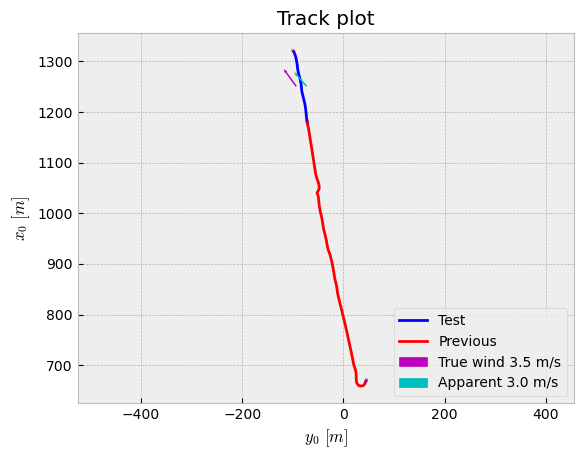

In [198]:
dataframes = {
    'Test':data,
    'Previous':data_previous,
              }
track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'], N=2)

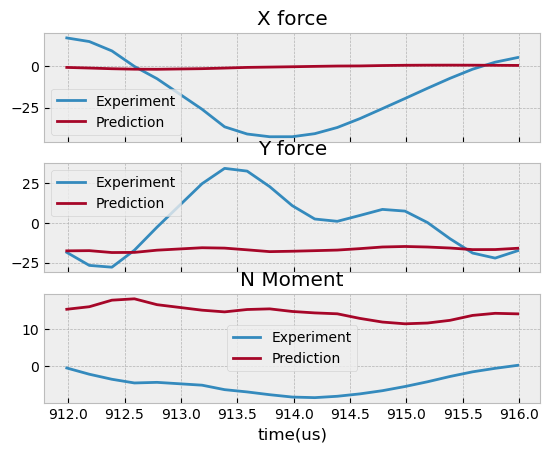

In [199]:
plot_total_force(model=model_wind, data=data_previous.iloc[-20:]);

<Axes: xlabel='time(us)'>

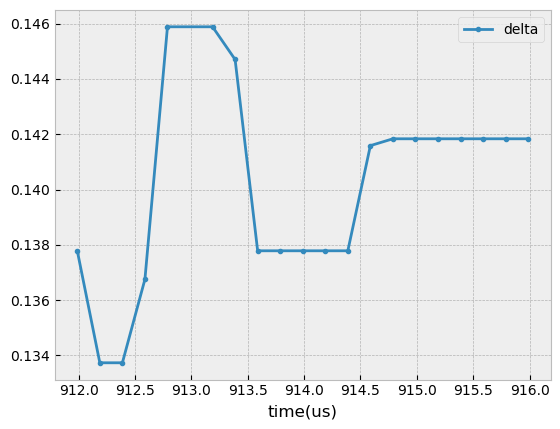

In [200]:
data_previous.iloc[-20:].plot(y='delta', style='.-')

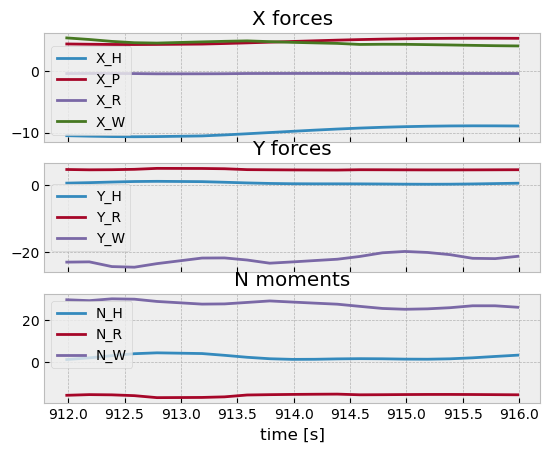

In [201]:
plot_force_components(model=model_wind, data=data_previous.iloc[-20:]);

In [202]:
df_predicted_forces = pd.DataFrame(model_wind.calculate_forces(states_dict=data_previous[model_wind.states_str], control=data_previous[model_wind.control_keys]))

In [203]:
result = fit(model=model_wind, data=data_previous.iloc[[-1]])

In [204]:
result.x

array([4.76590371, 0.08600452])

In [205]:
delta0_estimated = result.x[1]

In [206]:
rev_estimated = result.x[0]

In [207]:
ddelta0 = delta0_estimated - data['delta'].iloc[0]

In [208]:
np.rad2deg(ddelta0)

-3.1989041297327816

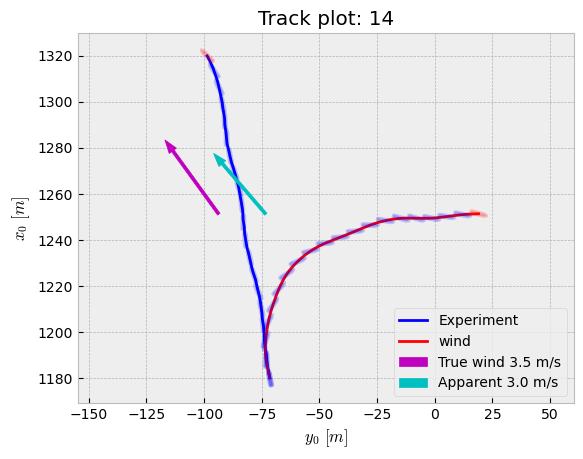

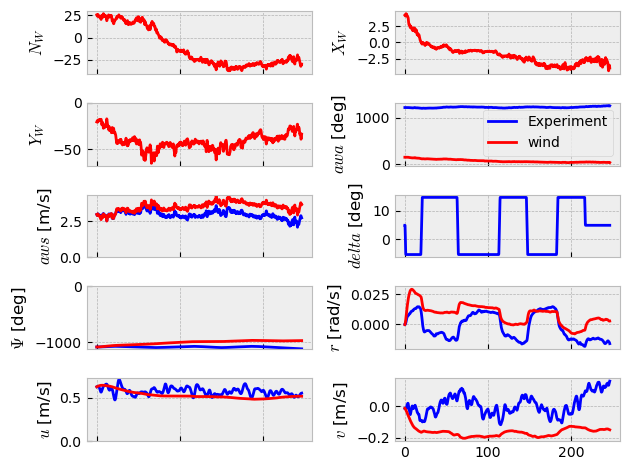

In [209]:
loader = time_series[id]
data = loader()
#data['awa'] = smallest_signed_angle(data['awa'])
#data['twa'] = mean_angle(data['twa'])
data.drop(columns=['mission','date'], inplace=True)

data['delta']+=ddelta0  # Neutral rudder angle added
data['rev'] = rev_estimated
result_wind = model_wind.simulate(data)


dataframes = {
    'Experiment':data,
    'wind':result_wind
}

time_window=[0,np.inf]

ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
                 time_window=time_window, N=20);
ax.legend(loc='lower right')
ax.set_title(f'Track plot: {id}') 

plot(dataframes, keys=['u','v','r','delta','psi','aws','awa','X_W','Y_W','N_W'], time_window=time_window, units=units, symbols=symbols_dict);

In [210]:
_=[]
for id, row in time_series_meta_data_select.iterrows():
    loader = time_series[id]
    
    data = loader()
    data.drop(columns=['mission','date'], inplace=True)
    set_initial_inputs(model=model_wind, data=data)
    _.append(pd.Series(data.iloc[0][['rev','delta']], name=id))
    
initial_inputs = pd.DataFrame(_)

In [211]:
initial_inputs

,rev,delta
0,18.029027,0.020776
1,16.119129,-0.226222
2,17.841905,0.128111
3,13.904667,-0.132746
4,14.365198,-0.019650
5,13.605314,0.178882
6,8.473461,0.051128
7,2.001408,0.035768
8,10.861572,-0.441501
9,5.026858,-0.453956


In [212]:
np.rad2deg(initial_inputs['delta'])

0      1.190364
1    -12.961568
2      7.340222
3     -7.605757
4     -1.125847
5     10.249175
6      2.929418
7      2.049339
8    -25.296163
9    -26.009767
10    13.326723
11   -14.611096
12    -4.906809
13     9.131170
14    45.000000
Name: delta, dtype: float64